<a href="https://colab.research.google.com/github/ivaaanrm/Word-vectors/blob/main/LanguageModelingTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""ImprovedLanguageModelingTransformer.py
"""

from types import SimpleNamespace
from collections import Counter
import os
import re
import pathlib
import array
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast
import logging

# Configure logging to display in terminal
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs

# Clear any existing handlers
if logger.handlers:
    logger.handlers.clear()

# Create console handler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create formatter
formatter = logging.Formatter(
    fmt='%(asctime)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
console_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(console_handler)

# Optionally add a file handler to keep logs in a file
file_handler = logging.FileHandler('/content/drive/MyDrive/SLPDL/output/training.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

logger.info("Logger initialized - outputs will appear in both terminal and training.log file")

class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def get_token(self, index):
        return self.idx2token[index]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

""" BUENO """

class ImprovedPredictor(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, context_words,
                 num_layers=4, num_heads=12, dropout=0.2,
                 ffn_dim_multiplier=4, share_embeddings=True,
                 pooling_type='weighted', layer_norm_eps=1e-12):
        """
        Enhanced Predictor model for word prediction with context.

        Parameters:
         - num_embeddings: vocabulary size
         - embedding_dim: dimension of word embeddings
         - context_words: total input sequence length (should be 7 for 3+1+3 window)
         - num_layers: number of transformer encoder layers
         - num_heads: number of attention heads
         - dropout: dropout rate for regularization
         - ffn_dim_multiplier: multiplier for feed-forward network dimension
         - share_embeddings: whether to share input and output embeddings
         - pooling_type: how to pool encoder outputs ('center', 'mean', 'weighted', 'concat')
         - layer_norm_eps: epsilon value for layer normalization
        """
        super(ImprovedPredictor, self).__init__()
        self.context_words = context_words
        self.pooling_type = pooling_type
        self.share_embeddings = share_embeddings
        self.embedding_dim = embedding_dim

        # Word embeddings
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        # Positional encoding with learnable weights
        self.register_buffer(
            "position_ids",
            torch.arange(context_words).expand((1, -1))
        )
        self.position_embeddings = nn.Embedding(context_words, embedding_dim)

        # Layer normalization and dropout for embedding outputs
        self.layer_norm = nn.LayerNorm(embedding_dim, eps=layer_norm_eps)
        self.emb_dropout = nn.Dropout(dropout)

        # Transformer encoder layers with higher capacity
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * ffn_dim_multiplier,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(embedding_dim, eps=layer_norm_eps)  # Add final layer norm
        )

        # Pooling mechanism components
        if pooling_type == 'weighted':
            # Attention-based weighted pooling
            self.attention_pool = nn.Sequential(
                nn.Linear(embedding_dim, embedding_dim // 2),
                nn.Tanh(),
                nn.Linear(embedding_dim // 2, 1),
                nn.Softmax(dim=1)
            )
        elif pooling_type == 'concat':
            # Concatenate all positions then project down
            self.concat_projection = nn.Sequential(
                nn.Linear(embedding_dim * context_words, embedding_dim * 2),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(embedding_dim * 2, embedding_dim)
            )

        # Output projection
        if share_embeddings:
            # We'll use the embedding weights transposed in the forward pass
            self.output_bias = nn.Parameter(torch.zeros(num_embeddings))
        else:
            self.output_projection = nn.Linear(embedding_dim, num_embeddings)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize the weights for better convergence"""
        # Initialize embedding layers
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)

        # Initialize linear layers
        if not self.share_embeddings:
            nn.init.normal_(self.output_projection.weight, mean=0.0, std=0.02)
            nn.init.zeros_(self.output_projection.bias)

        # Initialize pooling layers if needed
        if self.pooling_type == 'weighted':
            for module in self.attention_pool.modules():
                if isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)
        elif self.pooling_type == 'concat':
            for module in self.concat_projection.modules():
                if isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)

    def forward(self, input_ids):
        """
        Forward pass with enhanced pooling strategies.

        Args:
            input_ids: Input token IDs of shape [batch_size, context_words]

        Returns:
            logits: Prediction logits for the center word
        """
        batch_size, seq_len = input_ids.shape

        # Get embeddings from the input tokens
        embeddings = self.embeddings(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Add positional embeddings
        position_ids = self.position_ids[:, :seq_len]
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = embeddings + position_embeddings

        # Layer normalization and dropout
        embeddings = self.layer_norm(embeddings)
        embeddings = self.emb_dropout(embeddings)

        # Pass through transformer encoder
        encoder_output = self.transformer_encoder(embeddings)  # [batch_size, seq_len, embedding_dim]

        # Apply different pooling strategies
        if self.pooling_type == 'center':
            # Original method: extract center position
            center_idx = seq_len // 2
            pooled_output = encoder_output[:, center_idx, :]  # [batch_size, embedding_dim]

        elif self.pooling_type == 'mean':
            # Mean pooling across all positions
            pooled_output = torch.mean(encoder_output, dim=1)  # [batch_size, embedding_dim]

        elif self.pooling_type == 'weighted':
            # Attention-based weighted pooling
            attention_weights = self.attention_pool(encoder_output)  # [batch_size, seq_len, 1]
            pooled_output = torch.sum(attention_weights * encoder_output, dim=1)  # [batch_size, embedding_dim]

        elif self.pooling_type == 'concat':
            # Flatten and project all positions
            flat_output = encoder_output.reshape(batch_size, -1)  # [batch_size, seq_len * embedding_dim]
            pooled_output = self.concat_projection(flat_output)  # [batch_size, embedding_dim]

        # Project to vocabulary space
        if self.share_embeddings:
            # Use the transpose of the embedding matrix as the output projection
            logits = F.linear(pooled_output, self.embeddings.weight, self.output_bias)
        else:
            logits = self.output_projection(pooled_output)  # [batch_size, num_embeddings]

        return logits

    def get_word_embeddings(self):
        """Return the trained word embeddings for use in other tasks"""
        return self.embeddings.weight.data

""""""


class ImprovedPredictor(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, context_words,
                 num_layers=4, num_heads=12, dropout=0.2,
                 ffn_dim_multiplier=4, share_embeddings=True,
                 pooling_type='weighted', layer_norm_eps=1e-12):
        """
        Enhanced Predictor model for word prediction with context.

        Parameters:
         - num_embeddings: vocabulary size
         - embedding_dim: dimension of word embeddings
         - context_words: total input sequence length (should be 7 for 3+1+3 window)
         - num_layers: number of transformer encoder layers
         - num_heads: number of attention heads
         - dropout: dropout rate for regularization
         - ffn_dim_multiplier: multiplier for feed-forward network dimension
         - share_embeddings: whether to share input and output embeddings
         - pooling_type: how to pool encoder outputs ('center', 'mean', 'weighted', 'concat')
         - layer_norm_eps: epsilon value for layer normalization
        """
        super(ImprovedPredictor, self).__init__()
        self.context_words = context_words
        self.pooling_type = pooling_type
        self.share_embeddings = share_embeddings
        self.embedding_dim = embedding_dim

        # Word embeddings
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)

        # Positional encoding with learnable weights
        self.register_buffer(
            "position_ids",
            torch.arange(context_words).expand((1, -1))
        )
        self.position_embeddings = nn.Embedding(context_words, embedding_dim)

        # Layer normalization and dropout for embedding outputs
        self.layer_norm = nn.LayerNorm(embedding_dim, eps=layer_norm_eps)
        self.emb_dropout = nn.Dropout(dropout)

        # Transformer encoder layers with higher capacity
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=embedding_dim * ffn_dim_multiplier,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(embedding_dim, eps=layer_norm_eps)  # Add final layer norm
        )

        # Pooling mechanism components
        if pooling_type == 'weighted':
            # Attention-based weighted pooling
            self.attention_pool = nn.Sequential(
                nn.Linear(embedding_dim, embedding_dim // 2),
                nn.Tanh(),
                nn.Linear(embedding_dim // 2, 1),
                nn.Softmax(dim=1)
            )
        elif pooling_type == 'concat':
            # Enhanced concat pooling with adaptive handling of sequence length
            # Instead of hardcoding the input dimension, we'll use a more flexible approach
            self.concat_pooling = SequenceAdaptivePooling(embedding_dim)

        # Output projection
        if share_embeddings:
            # We'll use the embedding weights transposed in the forward pass
            self.output_bias = nn.Parameter(torch.zeros(num_embeddings))
        else:
            self.output_projection = nn.Linear(embedding_dim, num_embeddings)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize the weights for better convergence"""
        # Initialize embedding layers
        nn.init.normal_(self.embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)

        # Initialize linear layers
        if not self.share_embeddings:
            nn.init.normal_(self.output_projection.weight, mean=0.0, std=0.02)
            nn.init.zeros_(self.output_projection.bias)

        # Initialize pooling layers if needed
        if self.pooling_type == 'weighted':
            for module in self.attention_pool.modules():
                if isinstance(module, nn.Linear):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)

    def forward(self, input_ids):
        """
        Forward pass with enhanced pooling strategies.

        Args:
            input_ids: Input token IDs of shape [batch_size, seq_len]

        Returns:
            logits: Prediction logits for the center word
        """
        batch_size, seq_len = input_ids.shape

        # Get embeddings from the input tokens
        embeddings = self.embeddings(input_ids)  # [batch_size, seq_len, embedding_dim]

        # Add positional embeddings
        position_ids = self.position_ids[:, :seq_len]
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = embeddings + position_embeddings

        # Layer normalization and dropout
        embeddings = self.layer_norm(embeddings)
        embeddings = self.emb_dropout(embeddings)

        # Pass through transformer encoder
        encoder_output = self.transformer_encoder(embeddings)  # [batch_size, seq_len, embedding_dim]

        # Apply different pooling strategies
        if self.pooling_type == 'center':
            # Original method: extract center position
            center_idx = seq_len // 2
            pooled_output = encoder_output[:, center_idx, :]  # [batch_size, embedding_dim]

        elif self.pooling_type == 'mean':
            # Mean pooling across all positions
            pooled_output = torch.mean(encoder_output, dim=1)  # [batch_size, embedding_dim]

        elif self.pooling_type == 'weighted':
            # Attention-based weighted pooling
            attention_weights = self.attention_pool(encoder_output)  # [batch_size, seq_len, 1]
            pooled_output = torch.sum(attention_weights * encoder_output, dim=1)  # [batch_size, embedding_dim]

        elif self.pooling_type == 'concat':
            # Use the adaptive pooling that handles variable sequence lengths
            pooled_output = self.concat_pooling(encoder_output)  # [batch_size, embedding_dim]

        # Project to vocabulary space
        if self.share_embeddings:
            # Use the transpose of the embedding matrix as the output projection
            logits = F.linear(pooled_output, self.embeddings.weight, self.output_bias)
        else:
            logits = self.output_projection(pooled_output)  # [batch_size, num_embeddings]

        return logits

    def get_word_embeddings(self):
        """Return the trained word embeddings for use in other tasks"""
        return self.embeddings.weight.data


class SequenceAdaptivePooling(nn.Module):
    """
    Adaptive pooling layer that can handle variable sequence lengths.
    Uses self-attention to determine the importance of each position.
    """
    def __init__(self, embedding_dim):
        super(SequenceAdaptivePooling, self).__init__()
        self.embedding_dim = embedding_dim

        # Self-attention layer to weight sequence positions
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.Tanh(),
            nn.Linear(embedding_dim // 2, 1),
            nn.Softmax(dim=1)
        )

        # MLP to transform the context-aggregated representation
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.GELU(),
            nn.LayerNorm(embedding_dim)
        )

        # Initialize weights
        for module in self.attention.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

        for module in self.projection.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, sequence_output):
        """
        Apply adaptive pooling to sequence output.

        Args:
            sequence_output: Transformer output of shape [batch_size, seq_len, embedding_dim]

        Returns:
            pooled_output: Pooled representation of shape [batch_size, embedding_dim]
        """
        # Apply self-attention to get importance weights for each position
        attention_weights = self.attention(sequence_output)  # [batch_size, seq_len, 1]

        # Apply weighted sum to get context-aware representation
        weighted_sum = torch.sum(attention_weights * sequence_output, dim=1)  # [batch_size, embedding_dim]

        # Project to final representation
        pooled_output = self.projection(weighted_sum)  # [batch_size, embedding_dim]

        return pooled_output


def batch_generator(idata, target, batch_size, shuffle=True):
    nsamples = len(idata)
    if shuffle:
        perm = np.random.permutation(nsamples)
    else:
        perm = range(nsamples)

    for i in range(0, nsamples, batch_size):
        batch_idx = perm[i:i+batch_size]
        if target is not None:
            yield idata[batch_idx], target[batch_idx]
        else:
            yield idata[batch_idx], None


def load_preprocessed_dataset(prefix):
    # Try loading precomputed vocabulary and preprocessed data files
    token_vocab = Vocabulary()
    token_vocab.load(f'{prefix}.vocab')
    data = []
    for part in ['train', 'valid', 'test']:
        with np.load(f'{prefix}.{part}.npz') as set_data:
            idata, target = set_data['idata'], set_data['target']
            data.append((idata, target))
            logger.info(f'Number of samples ({part}): {len(target)}')
    logger.info("Using precomputed vocabulary and data files")
    logger.info(f'Vocabulary size: {len(token_vocab)}')
    return token_vocab, data


def get_lr_scheduler(optimizer, warmup_steps, total_steps):
    """Get a cosine learning rate scheduler with warmup."""
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def train(model, criterion, optimizer, scheduler, idata, target, batch_size,
          device, log=False, grad_clip=1.0, use_amp=True, log_interval=100):
    """
    Advanced training function with mixed precision and monitoring

    Args:
        model: The neural network model
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        idata: Input data
        target: Target data
        batch_size: Batch size
        device: Device to train on (cuda/cpu)
        log: Whether to log training progress
        grad_clip: Maximum gradient norm for gradient clipping
        use_amp: Whether to use automatic mixed precision
        log_interval: How often to log progress

    Returns:
        tuple: (accuracy, loss)
    """
    batch_losses = []
    model.train()
    total_loss = 0
    ncorrect = 0
    ntokens = 0
    niterations = 0

    # For mixed precision training
    scaler = GradScaler('cuda') if use_amp else None

    # Progress tracking
    start_time = time.time()
    log_interval = max(1, len(idata) // (batch_size * 20))  # Log roughly 20 times per epoch

    for X, y in batch_generator(idata, target, batch_size, shuffle=True):
        # Get input and target sequences from batch
        X = torch.tensor(X, dtype=torch.long, device=device)
        y = torch.tensor(y, dtype=torch.long, device=device)

        # Forward pass with mixed precision
        optimizer.zero_grad()

        if use_amp:
            with torch.amp.autocast('cuda'):
                output = model(X)
                loss = criterion(output, y)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()

            # Gradient clipping
            if grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # Update weights with scaler
            scaler.step(optimizer)
            scaler.update()

            # Update learning rate (after optimizer step)
            scheduler.step()
        else:
            # Standard training without mixed precision
            output = model(X)
            loss = criterion(output, y)
            loss.backward()

            # Gradient clipping
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # Update weights
            optimizer.step()

            # Update learning rate (after optimizer step)
            scheduler.step()

        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        ntokens += y.numel()
        niterations += 1

        # Periodic progress update
        if niterations == 50 or niterations == 200 or niterations == 500 or niterations % 1000 == 0:
            avg_loss = total_loss / ntokens
            avg_acc = 100 * ncorrect / ntokens
            logger.info(f'Train: wpb={ntokens//niterations}, updates={niterations}, accuracy={avg_acc:.1f}, loss={avg_loss:.2f}')

        # Detailed logging at intervals
        if niterations % log_interval == 0:
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = loss.item() / y.numel()
            cur_accuracy = 100 * (torch.max(output, 1)[1] == y).sum().item() / y.numel()
            cur_lr = scheduler.get_last_lr()[0]

            logger.info(f'| batch {niterations:5d}/{len(idata)//batch_size:5d} | '
                  f'ms/batch {ms_per_batch:5.2f} | '
                  f'lr {cur_lr:.6f} | '
                  f'acc {cur_accuracy:5.2f}% | '
                  f'loss {cur_loss:5.2f}')

            batch_losses.append((niterations, cur_loss))
            start_time = time.time()

    # Final statistics
    total_loss = total_loss / ntokens
    accuracy = 100 * ncorrect / ntokens

    if log:
        logger.info(f'Train: samples={ntokens}, updates={niterations}, '
              f'accuracy={accuracy:.2f}%, loss={total_loss:.4f}')

    # Plot batch losses if there are enough points
    if len(batch_losses) > 1:
        plot_batch_loss(batch_losses)

    return accuracy, total_loss


def evaluate(model, criterion, idata, target, batch_size, device, desc="Validation", use_amp=False):
    """
    Improved evaluation function with mixed precision support

    Args:
        model: The neural network model
        criterion: Loss function
        idata: Input data
        target: Target data
        batch_size: Batch size
        device: Device to evaluate on (cuda/cpu)
        desc: Description for logging
        use_amp: Whether to use automatic mixed precision

    Returns:
        tuple: (accuracy, loss, predictions)
    """
    model.eval()
    total_loss = 0
    ncorrect = 0
    ntokens = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for X, y in batch_generator(idata, target, batch_size, shuffle=False):
            # Get input and target sequences from batch
            X = torch.tensor(X, dtype=torch.long, device=device)

            # Use mixed precision if requested
            if use_amp:
                with autocast('cuda'):
                    output = model(X)

                    if target is not None:
                        y = torch.tensor(y, dtype=torch.long, device=device)
                        loss = criterion(output, y)
            else:
                output = model(X)

                if target is not None:
                    y = torch.tensor(y, dtype=torch.long, device=device)
                    loss = criterion(output, y)

            # Get predictions
            predictions = torch.max(output, 1)[1]
            y_pred.append(predictions.cpu().numpy())

            if target is not None:
                total_loss += loss.item()
                ncorrect += (predictions == y).sum().item()
                ntokens += y.numel()
                y_true.append(y.cpu().numpy())

    # Combine predictions
    predictions = np.concatenate(y_pred) if y_pred else None

    if target is not None:
        # Calculate metrics
        total_loss = total_loss / ntokens
        accuracy = 100 * ncorrect / ntokens

        # Calculate perplexity
        perplexity = math.exp(total_loss)

        # Print evaluation results
        logger.info(f'| {desc} | accuracy={accuracy:.2f}%, loss={total_loss:.4f}, ppl={perplexity:.2f}')

        return accuracy, total_loss, predictions
    else:
        return None, None, predictions


def save_results(results, filename="results.csv"):
    """Saves the results to a CSV file."""
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)
    logger.info(f"Results saved to {filename}")


def plot_loss_accuracy(results, filename="loss_accuracy.png"):
    """Creates a plot of loss and accuracy over epochs for each model."""
    num_models = len(results)
    fig, axes = plt.subplots(num_models, 2, figsize=(15, 7 * num_models))

    for i, result in enumerate(results):
        model_name = result['Model']
        epochs = range(1, len(result['Loss']) + 1)

        # Loss Plot
        ax1 = axes[i, 0] if num_models > 1 else axes[0]
        ax1.plot(epochs, result['Loss'], 'b-', label='Training Loss')
        ax1.plot(epochs, result.get('Wiki_loss', []), 'g-', label='Wiki Loss')
        ax1.plot(epochs, result.get('Valid_loss', []), 'r-', label='El Periodico Loss')
        ax1.set_title(f'{model_name} - Losses')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Accuracy Plot
        ax2 = axes[i, 1] if num_models > 1 else axes[1]
        ax2.plot(epochs, result['Accuracy'], 'b-', label='Training Accuracy')
        ax2.plot(epochs, result.get('Wiki_acc', []), 'g-', label='Wiki Accuracy')
        ax2.plot(epochs, result.get('Valid_acc', []), 'r-', label='El Periodico Accuracy')
        ax2.set_title(f'{model_name} - Accuracies')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.grid(True)
        ax2.legend()

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    logger.info(f"Loss and accuracy plot saved to {filename}")
    plt.show()


def plot_batch_loss(batch_losses, filename="batch_loss.png"):
    """Creates a plot of the training loss for each batch."""
    iterations, losses = zip(*batch_losses)  # Unpack the list of tuples
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, losses, 'b-')
    plt.title('Training Loss per Batch')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(filename, dpi=300)
    logger.info(f"Batch loss plot saved to {filename}")
    plt.close()


class TopKFrequencyPenaltyLoss(nn.Module):
    """
    Loss function that applies additional penalties only to the top-K most frequent tokens.

    This is more efficient for large vocabularies as it only tracks and penalizes
    a small subset of extremely common tokens that might dominate predictions.
    """
    def __init__(self, base_criterion, k=1000, penalty_factor=0.2):
        """
        Initialize the loss function with a base criterion and parameters.

        Args:
            base_criterion: Base loss function (like CrossEntropyLoss)
            k: Number of most frequent tokens to apply penalties to
            penalty_factor: How much extra penalty to apply (0.2 = 20% extra loss)
        """
        super(TopKFrequencyPenaltyLoss, self).__init__()
        self.base_criterion = base_criterion
        self.k = k
        self.penalty_factor = penalty_factor
        self.frequent_tokens = None

    def identify_frequent_tokens(self, targets, k=None):
        """
        Identify the k most frequent tokens in the training data.

        Args:
            targets: Training target indices (can be tensor or numpy array)
            k: Override for number of tokens to track
        """
        if k is not None:
            self.k = k

        # Convert to numpy if it's a tensor
        if isinstance(targets, torch.Tensor):
            targets = targets.cpu().numpy()

        # Count token frequencies
        counter = Counter(targets.flatten())

        # Get the k most common tokens
        most_common = counter.most_common(self.k)
        self.frequent_tokens = set(token for token, _ in most_common)

        # Log the most frequent tokens if logger is available
        try:
            logging.info(f"Identified {len(self.frequent_tokens)} most frequent tokens for special handling")
        except:
            pass

        return self.frequent_tokens

    def forward(self, logits, targets):
        """
        Forward pass applying the penalty to most common tokens.

        Args:
            logits: Model prediction logits
            targets: Target token indices

        Returns:
            Loss with additional penalty for common tokens
        """
        # Get base loss
        base_loss = self.base_criterion(logits, targets)

        # If we haven't identified frequent tokens yet, just return base loss
        if self.frequent_tokens is None:
            return base_loss

        # Get predicted tokens
        _, predicted = torch.max(logits, dim=1)

        # Count how many predictions are in the frequent token set
        frequent_mask = torch.tensor(
            [token.item() in self.frequent_tokens for token in predicted],
            device=logits.device
        )

        # Only apply penalty when prediction is a frequent token but target is different
        incorrect_frequent = frequent_mask & (predicted != targets)

        # If no frequent tokens were incorrectly predicted, just return base loss
        if not torch.any(incorrect_frequent):
            return base_loss

        # Calculate frequency penalty (only for incorrect predictions of frequent tokens)
        penalty = self.penalty_factor * base_loss * (torch.sum(incorrect_frequent) / len(targets))

        return base_loss + penalty

def main():
    # Paths and parameters setup
    DATASET_VERSION = 'ca-wiki'
    DATASET_PREFIX = 'ca.wiki'
    COMPETITION_ROOT = "/content/drive/MyDrive/SLPDL/data"
    DATASET_ROOT = f'/content/drive/MyDrive/SLPDL/ca-100/{DATASET_PREFIX}'
    WORKING_ROOT = f'/content/drive/MyDrive/SLPDL/output'

    # Configuration parameters
    params = SimpleNamespace(
        model_name = "ImprovedWordPredictor_v2",
        embedding_dim = 768,         # Increased embedding dimension
        window_size = 7,             # Total sequence length (3 before, 1 center, 3 after)
        batch_size = 3072,            # Adjusted to balance speed/memory
        epochs = 8,                 # More epochs for better convergence
        lr = 8e-4,                   # Adjusted learning rate
        weight_decay = 0.01,         # L2 regularization
        warmup_ratio = 0.05,          # Warmup ratio instead of fixed steps
        preprocessed = DATASET_ROOT,
        working = WORKING_ROOT,
        modelname = f'{WORKING_ROOT}/improved_model_v2.pt',
        train = True,
        transformer_layers = 4,      # More transformer layers
        transformer_heads = 12,      # More attention heads
        dropout = 0.2,               # Increased dropout
        ffn_dim_multiplier = 4,      # Feedforward network size multiplier
        share_embeddings = True,     # Share input/output embeddings
        pooling_type = 'concat',   # Attention-weighted pooling
        label_smoothing = 0.1,       # Label smoothing factor
        use_amp = True,              # Use automatic mixed precision
        grad_clip = 1.0,             # Gradient clipping value
    )
    logger.info(f"Configuration: {params}")

    # Create working directory
    pathlib.Path(WORKING_ROOT).mkdir(parents=True, exist_ok=True)

    # Select device
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Print GPU info
        logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
        logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    else:
        device = torch.device('cpu')
        logger.warning("WARNING: Training without GPU can be very slow!")

    # Load dataset
    vocab, data = load_preprocessed_dataset(params.preprocessed)

    # Load competition validation dataset
    valid_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_valid.csv')
    tokens = valid_x_df.columns[1:]
    valid_x = valid_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')
    valid_y_df = pd.read_csv(f'{COMPETITION_ROOT}/y_valid.csv')
    valid_y = valid_y_df['token'].apply(vocab.get_index).to_numpy(dtype='int32')

    logger.info("Dataset loaded successfully!")

    # Initialize the improved model
    model = ImprovedPredictor(
        num_embeddings=len(vocab),
        embedding_dim=params.embedding_dim,
        context_words=params.window_size,
        num_layers=params.transformer_layers,
        num_heads=params.transformer_heads,
        dropout=params.dropout,
        ffn_dim_multiplier=params.ffn_dim_multiplier,
        share_embeddings=params.share_embeddings,
        pooling_type=params.pooling_type
    ).to(device)

    # Print model architecture and parameter count
    logger.info(f"Model Architecture:\n{model}")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    logger.info(f'Total parameters: {total_params:,}')
    logger.info(f'Trainable parameters: {trainable_params:,}')

    # Prepare optimizer with weight decay separation
    no_decay = ['bias', 'layer_norm', 'embedding']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters()
                      if not any(nd in n.lower() for nd in no_decay)],
            'weight_decay': params.weight_decay
        },
        {
            'params': [p for n, p in model.named_parameters()
                      if any(nd in n.lower() for nd in no_decay)],
            'weight_decay': 0.0
        }
    ]

    # Use AdamW optimizer
    optimizer = torch.optim.AdamW(
        optimizer_grouped_parameters,
        lr=params.lr,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Calculate warmup steps based on ratio
    steps_per_epoch = len(data[0][0]) // params.batch_size
    total_steps = steps_per_epoch * params.epochs
    warmup_steps = int(params.warmup_ratio * total_steps)
    logger.info(f"Training for {total_steps} steps with {warmup_steps} warmup steps")

    # Get learning rate scheduler
    scheduler = get_lr_scheduler(optimizer, warmup_steps, total_steps)

    # Loss function with label smoothing
    # criterion = nn.CrossEntropyLoss(reduction='sum', label_smoothing=params.label_smoothing)

    # First create the base criterion
    base_criterion = nn.CrossEntropyLoss(reduction='sum', label_smoothing=params.label_smoothing)

    # Then wrap it with the frequency penalty
    criterion = TopKFrequencyPenaltyLoss(
        base_criterion=base_criterion,
        k=100,  # Only target the top 1000 most frequent tokens
        penalty_factor=0.3  # 30% additional penalty for common tokens
    )

    # Before training, identify the frequent tokens
    criterion.identify_frequent_tokens(data[0][1])

    # Initialize tracking variables
    train_accuracy = []
    wiki_accuracy = []
    valid_accuracy = []
    train_losses = []
    wiki_losses = []
    valid_losses = []
    results = []
    best_valid_loss = float('inf')

    # Start training
    logger.info("=== Starting Training ===")
    start_time = time.time()

    for epoch in range(params.epochs):
        epoch_start = time.time()
        logger.info(f"Epoch {epoch+1}/{params.epochs}")

        # Train for one epoch
        acc, loss = train(
            model, criterion, optimizer, scheduler,
            data[0][0], data[0][1], params.batch_size, device,
            log=True, grad_clip=params.grad_clip, use_amp=params.use_amp
        )
        train_accuracy.append(acc)
        train_losses.append(loss)

        # Evaluate on Wikipedia validation set
        wiki_acc, wiki_loss, _ = evaluate(
            model, criterion, data[1][0], data[1][1],
            params.batch_size, device, desc="Wikipedia",
            use_amp=params.use_amp
        )
        wiki_accuracy.append(wiki_acc)
        wiki_losses.append(wiki_loss)

        # Evaluate on competition validation set
        valid_acc, valid_loss, _ = evaluate(
            model, criterion, valid_x, valid_y,
            params.batch_size, device, desc="El Periodico",
            use_amp=params.use_amp
        )
        valid_accuracy.append(valid_acc)
        valid_losses.append(valid_loss)

        # Save checkpoint if validation improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            logger.info(f"New best model with validation loss: {valid_loss:.4f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'valid_loss': valid_loss,
                'valid_acc': valid_acc,
            }, params.modelname)

        # Log epoch time
        epoch_time = time.time() - epoch_start
        logger.info(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")

        # Plot intermediate results every few epochs
        if (epoch + 1) % 3 == 0:
            # Create interim results for plotting
            interim_results = [{
                'Model': params.model_name,
                'Loss': train_losses,
                'Accuracy': train_accuracy,
                'Wiki_acc': wiki_accuracy,
                'Valid_acc': valid_accuracy,
                'Wiki_loss': wiki_losses,
                'Valid_loss': valid_losses,
            }]
            plot_loss_accuracy(interim_results, f"{WORKING_ROOT}/progress_epoch_{epoch+1}.png")

    # Calculate total training time
    total_time = time.time() - start_time
    logger.info(f"Training completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    try:
        logger.info(f"Loading model from {params.modelname}...")
        try:
            add_safe_globals([SimpleNamespace])
            # Try with weights_only=True (safer)
            checkpoint = torch.load(params.modelname)
        except Exception as e:
            logger.warning(f"Could not load with weights_only=True: {e}")
            logger.warning("Attempting to load with weights_only=False")
            # Fallback to weights_only=False
            checkpoint = torch.load(params.modelname, weights_only=False)

        # Load state dict
        model.load_state_dict(checkpoint['model_state_dict'])
        logger.info(f"Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")

        # logger.info(f"Loaded best model from epoch {best_checkpoint['epoch']+1} with validation loss {best_checkpoint['valid_loss']:.4f}")

        # Generate predictions for test set
        logger.info("Generating test predictions...")
        test_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_test.csv')
        test_x = test_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')

        _, _, y_pred = evaluate(model, None, test_x, None, params.batch_size, device, desc="Test")

        # Convert predictions to tokens
        y_token = [vocab.get_token(index) for index in y_pred]

        # Create submission file
        submission = pd.DataFrame({'id': test_x_df['id'], 'token': y_token}, columns=['id', 'token'])
        submission.to_csv(f'{WORKING_ROOT}/submission.csv', index=False)
        logger.info(f"Submission file saved to {WORKING_ROOT}/submission.csv")

        # Save final results
        results.append({
            'Model': params.model_name,
            'Loss': train_losses,
            'Accuracy': train_accuracy,
            'Wiki_acc': wiki_accuracy,
            'Valid_acc': valid_accuracy,
            'Wiki_loss': wiki_losses,
            'Valid_loss': valid_losses,
            'Training Time (s)': total_time,
            'Parameters': total_params,
            'Hyperparameters': {
                'Layers': params.transformer_layers,
                'Embed_dim': params.embedding_dim,
                'Heads': params.transformer_heads,
                'Dropout': params.dropout,
                'Pooling': params.pooling_type,
                'Share_embeddings': params.share_embeddings
            }
        })

        save_results(results, f"{WORKING_ROOT}/results.csv")
        plot_loss_accuracy(results, f"{WORKING_ROOT}/final_results.png")

        logger.info("All done!")
    except Exception as e:
        logger.exception(f"An error occurred: {e}")

2025-03-30 07:16:49 | INFO | Logger initialized - outputs will appear in both terminal and training.log file


2025-03-30 07:16:49 | INFO | Configuration: namespace(model_name='ImprovedWordPredictor_v2', embedding_dim=768, window_size=7, batch_size=3072, epochs=8, lr=0.0008, weight_decay=0.01, warmup_ratio=0.05, preprocessed='/content/drive/MyDrive/SLPDL/ca-100/ca.wiki', working='/content/drive/MyDrive/SLPDL/output', modelname='/content/drive/MyDrive/SLPDL/output/improved_model_v2.pt', train=True, transformer_layers=4, transformer_heads=12, dropout=0.2, ffn_dim_multiplier=4, share_embeddings=True, pooling_type='concat', label_smoothing=0.1, use_amp=True, grad_clip=1.0)
2025-03-30 07:16:49 | INFO | Using GPU: NVIDIA A100-SXM4-40GB
2025-03-30 07:16:49 | INFO | GPU Memory: 42.47 GB
2025-03-30 07:18:12 | INFO | Number of samples (train): 82284341
2025-03-30 07:18:15 | INFO | Number of samples (valid): 164765
2025-03-30 07:18:18 | INFO | Number of samples (test): 165837
2025-03-30 07:18:18 | INFO | Using precomputed vocabulary and data files
2025-03-30 07:18:18 | INFO | Vocabulary size: 100002
2025-

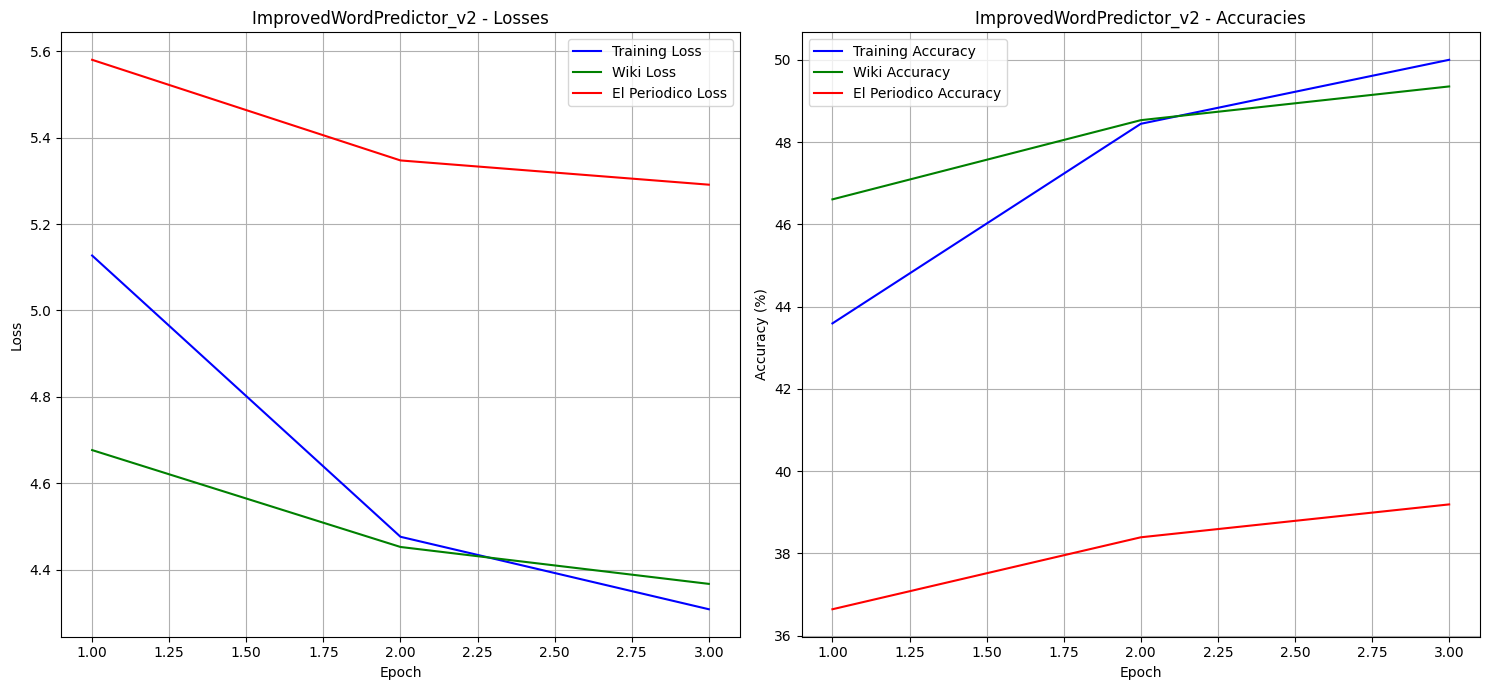

2025-03-30 10:20:14 | INFO | Epoch 4/8
2025-03-30 10:20:25 | INFO | Train: wpb=3072, updates=50, accuracy=50.8, loss=4.20
2025-03-30 10:20:45 | INFO | Train: wpb=3072, updates=200, accuracy=50.9, loss=4.21
2025-03-30 10:21:26 | INFO | Train: wpb=3072, updates=500, accuracy=50.9, loss=4.20
2025-03-30 10:22:33 | INFO | Train: wpb=3072, updates=1000, accuracy=50.9, loss=4.20
2025-03-30 10:23:19 | INFO | | batch  1339/26785 | ms/batch 138.22 | lr 0.000583 | acc 51.60% | loss  4.08
2025-03-30 10:24:49 | INFO | Train: wpb=3072, updates=2000, accuracy=50.9, loss=4.21
2025-03-30 10:26:21 | INFO | | batch  2678/26785 | ms/batch 135.42 | lr 0.000576 | acc 51.89% | loss  4.10
2025-03-30 10:27:04 | INFO | Train: wpb=3072, updates=3000, accuracy=50.9, loss=4.21
2025-03-30 10:29:19 | INFO | Train: wpb=3072, updates=4000, accuracy=50.9, loss=4.21
2025-03-30 10:29:21 | INFO | | batch  4017/26785 | ms/batch 135.01 | lr 0.000568 | acc 49.54% | loss  4.30
2025-03-30 10:31:34 | INFO | Train: wpb=3072, upd

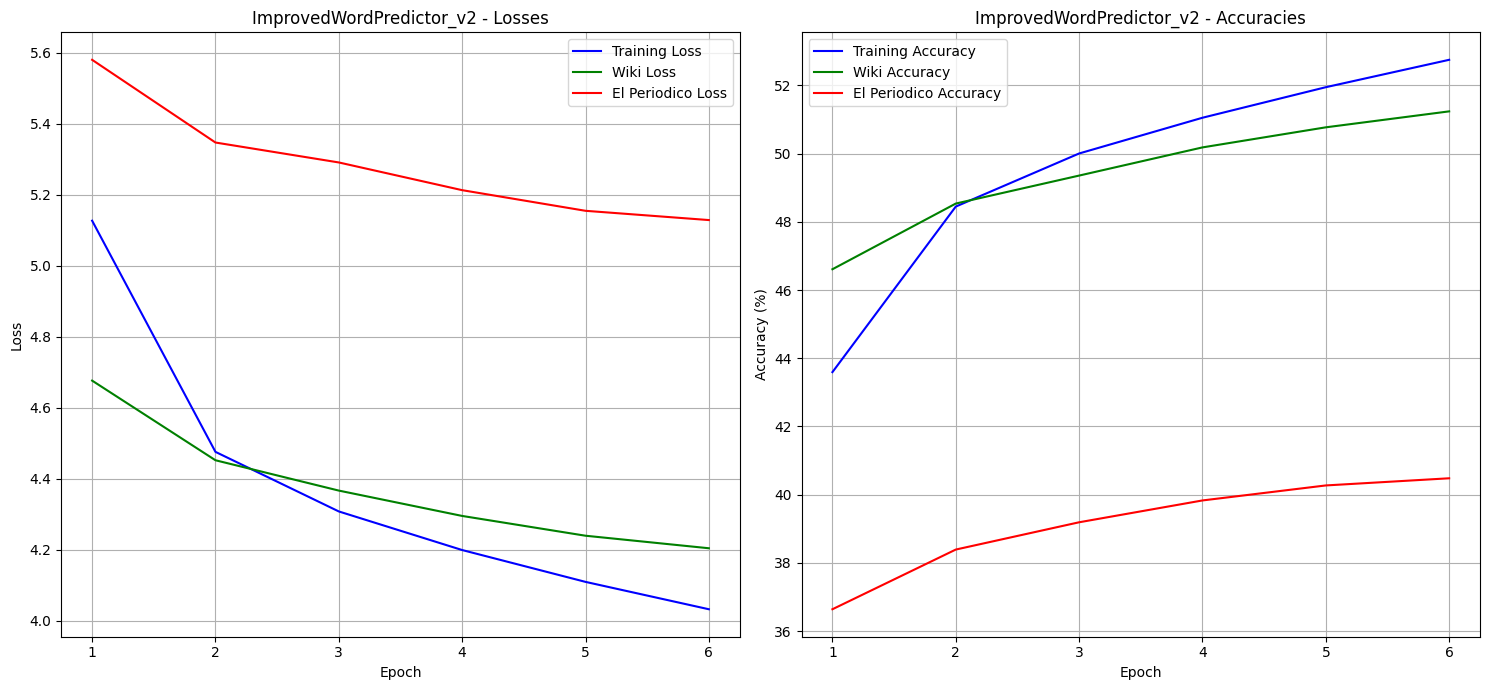

2025-03-30 13:21:23 | INFO | Epoch 7/8
2025-03-30 13:21:34 | INFO | Train: wpb=3072, updates=50, accuracy=53.2, loss=3.98
2025-03-30 13:21:54 | INFO | Train: wpb=3072, updates=200, accuracy=53.3, loss=3.98
2025-03-30 13:22:35 | INFO | Train: wpb=3072, updates=500, accuracy=53.3, loss=3.97
2025-03-30 13:23:42 | INFO | Train: wpb=3072, updates=1000, accuracy=53.3, loss=3.97
2025-03-30 13:24:28 | INFO | | batch  1339/26785 | ms/batch 138.09 | lr 0.000123 | acc 53.94% | loss  3.97
2025-03-30 13:25:57 | INFO | Train: wpb=3072, updates=2000, accuracy=53.3, loss=3.97
2025-03-30 13:27:29 | INFO | | batch  2678/26785 | ms/batch 134.97 | lr 0.000117 | acc 54.56% | loss  3.91
2025-03-30 13:28:12 | INFO | Train: wpb=3072, updates=3000, accuracy=53.3, loss=3.98
2025-03-30 13:30:27 | INFO | Train: wpb=3072, updates=4000, accuracy=53.3, loss=3.98
2025-03-30 13:30:29 | INFO | | batch  4017/26785 | ms/batch 134.72 | lr 0.000111 | acc 55.01% | loss  3.89
2025-03-30 13:32:42 | INFO | Train: wpb=3072, upd

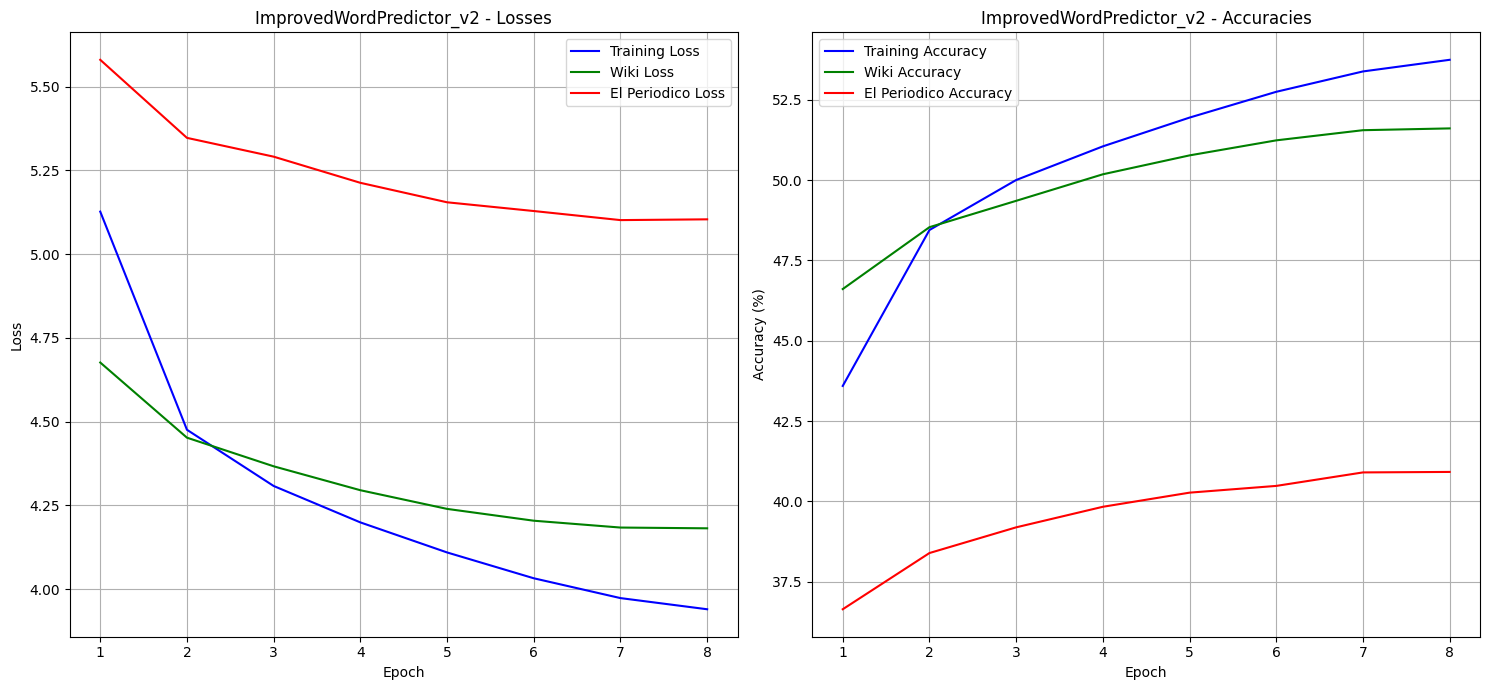

2025-03-30 15:22:09 | INFO | All done!


In [ ]:
try:
    main()
except Exception as e:
    logger.exception(f"An error occurred: {e}")

## Predict

In [ ]:
from torch.serialization import add_safe_globals

def generate_predictions(model, idata, batch_size, device):
    """Generate predictions without computing loss"""
    model.eval()
    y_pred = []

    with torch.no_grad():
        for X, _ in batch_generator(idata, None, batch_size, shuffle=False):
            # Get input sequence
            X = torch.tensor(X, dtype=torch.long, device=device)

            # Forward pass
            output = model(X)

            # Get predictions
            predictions = torch.max(output, 1)[1]
            y_pred.append(predictions.cpu().numpy())

    # Concatenate predictions
    predictions = np.concatenate(y_pred) if y_pred else None
    return predictions

def main():
    # Add SimpleNamespace to safe globals for checkpoint loading
    add_safe_globals([SimpleNamespace])

    # Configuration
    COMPETITION_ROOT = "/content/drive/MyDrive/SLPDL/data"
    DATASET_ROOT = "/content/drive/MyDrive/SLPDL/ca-100/ca.wiki"
    MODEL_PATH = "/content/drive/MyDrive/SLPDL/output/improved_model_v2.pt"
    OUTPUT_PATH = "/content/drive/MyDrive/SLPDL/output/submission.csv"
    BATCH_SIZE = 2048

    # Select device
    if torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        logger.warning("Using CPU for inference - this will be slower")

    # Load vocabulary
    logger.info("Loading vocabulary...")
    vocab = Vocabulary()
    vocab.load(f'{DATASET_ROOT}.vocab')
    logger.info(f"Vocabulary size: {len(vocab)}")

    # Load test data
    logger.info("Loading test data...")
    test_x_df = pd.read_csv(f'{COMPETITION_ROOT}/x_test.csv')
    tokens = test_x_df.columns[1:]  # Skip 'id' column
    test_x = test_x_df[tokens].apply(vocab.get_index).to_numpy(dtype='int32')
    logger.info(f"Test data loaded with {test_x.shape[0]} samples")

    # Model parameters
    model_params = {
        'num_embeddings': len(vocab),
        'embedding_dim': 480,
        'context_words': 7,
        'num_layers': 3,
        'num_heads': 8,
        'dropout': 0.2,
        'ffn_dim_multiplier': 4,
        'share_embeddings': True,
        'pooling_type': 'weighted'
    }

    # Initialize model
    logger.info("Initializing model...")
    model = ImprovedPredictor(**model_params).to(device)

    # Load model weights
    logger.info(f"Loading model from {MODEL_PATH}...")
    try:
        # Try with weights_only=True (safer)
        checkpoint = torch.load(MODEL_PATH)
    except Exception as e:
        logger.warning(f"Could not load with weights_only=True: {e}")
        logger.warning("Attempting to load with weights_only=False")
        # Fallback to weights_only=False
        checkpoint = torch.load(MODEL_PATH, weights_only=False)

    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    logger.info(f"Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")

    # Generate predictions
    logger.info("Generating predictions...")
    y_pred = generate_predictions(model, test_x, BATCH_SIZE, device)
    logger.info(f"Generated {len(y_pred)} predictions")

    # Convert indices to tokens
    y_token = [vocab.get_token(index) for index in y_pred]

    # Create submission file
    logger.info("Creating submission file...")
    submission = pd.DataFrame({'id': test_x_df['id'], 'token': y_token}, columns=['id', 'token'])
    submission.to_csv(OUTPUT_PATH, index=False)
    logger.info(f"Submission saved to {OUTPUT_PATH}")

    # Display sample predictions
    logger.info("Sample predictions:")
    logger.info(submission.head().to_string())

    logger.info("Prediction script completed successfully!")
